# Business Question 1

The government wants to ensure its economy is growing. Every year several companies are created as well as dissolved. To support companies from dissolving, the government wants to know the amount of money it has to keep aside and it should be presented in the upcoming budget meeting. The officials require the trend of dissolving of companies in the sectors: Agriculture, Poultry Farming and producing Processed Food.

# Business Question 2

An investment company wants to expand the sectors in which it would like to invest. It has decided to invest in renting and leasing, retail and wholesale sectors. But it will invest in companies that were registered during the COVID-19 pandemic to see which sector is robust for promising returns. 

### Business Question 1: Code:

In [ ]:
raise NotImplementedError()

In [31]:
# Importing libraries
!pip3 install requests
import requests
import pprint as pp
import datetime
from datetime import date 
from datetime import datetime
import math
import time
import pickle
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [32]:
# function for calling the API to retrieve JSON
def call_api_with(url_extension):
    your_company_house_api_key ="fdfc7d90-70b1-4660-85ac-807e40cb8d72"
            
    login_headers = {"Authorization":your_company_house_api_key}
    url = f"https://api.company-information.service.gov.uk/{url_extension}"
    # above: could be eg. https://api.companieshouse.gov.uk/search/companies?q=shop&items_per_page=1
    print(f'requesting: {url}') 
    # above, optional: printing, so that you see visually how many calls you are making
    res = requests.get(url, headers=login_headers) #, verify=False)
    return res.json()

In [33]:
# advanced search - SIC codes & Date 
def companies_advanced_search(sic, number_of_companies):
    page_size = 100
    iterations_req = math.ceil(number_of_companies/page_size)
    companies = []
    for page_index in range(0, iterations_req):
        print('#Request: {0}'.format(page_index))
        url = f"advanced-search/companies?sic_codes={sic}&start_index={page_index*100}"
        companies += call_api_with(url).get('items', [])
    return page_index, companies

In [34]:
# function to write company information into a file
def read_write_company_information_to_pickle(sic_codes_list, company_details, company_details_df):
    no_of_requests = 1
    for i in range(0,len(sic_codes_list),4):
        for sic in sic_codes_list[i:i+4]:
            try:
                print('Try triggered')
                if no_of_requests%600!=0:
                    print('Requesting')
                    no_of_requests, company_details = companies_advanced_search(sic,10000) 
                    company_details_api_output_df = pd.DataFrame(company_details)
                    json_struct = json.loads(company_details_api_output_df.to_json(orient="records"))    
                    df_flat = pd.json_normalize(json_struct)
                    company_details_df = pd.concat([company_details_df, df_flat])
                    print('Saving to pickle file')
                    company_details_df.to_pickle('company_details.pkl')
                else:
                    print('Time delay for new window to start')
                    time.sleep(300)
            except:
                print('Except triggered')
                continue
        time.sleep(300)

In [35]:
# function to read from file
def reading_from_pickle(file_name):
    company_information=pd.DataFrame()
    for index in file_name:
        print(index)
        with open(index, "rb") as company_batch_file:  
            company_information=pd.concat((pickle.load(company_batch_file),company_information))
    return company_information

In [36]:
#list of sic codes for various sectors

sic_codes_list_agriculture = [1110, 1120, 1130, 1140, 1150, 1160, 1190, 1210, 1220, 1230, 1240, 1250, 1260, 1270, 1280, 1290]
sic_codes_list_processed_food = [10110, 10120, 10130, 10200, 10310, 10320, 10390, 10410, 10420, 10511, 10512, 10519, 10520, 10611, 10612, 10620, 10710, 10720, 10730, 10810, 10821, 10822, 10831, 10832, 10840, 10850, 10860, 10890]
sic_codes_list_poultry_farming = [1410, 1420, 1430, 1440, 1450, 1460, 1470, 1490]

In [37]:
# lists and dataframes for various sectors in consideration
company_details_agriculture = []
company_details_df_agriculture = pd.DataFrame()

company_details_processed_food = []
company_details_df_processed_food = pd.DataFrame()

company_details_poultry_farming = []
company_details_df_poultry_farming = pd.DataFrame()

#Calling functions to request the company data in sectors: Agriculture, Processed Food, Poultry Farming
#read_write_company_information_to_pickle(sic_codes_list_processed_food, company_details_processed_food, company_details_df_processed_food)
#read_write_company_information_to_pickle(sic_codes_list_poultry_farming, company_details_poultry_farming, company_details_df_poultry_farming)
#read_write_company_information_to_pickle(sic_codes_list_agriculture, company_details_agriculture, company_details_df_agriculture)

In [38]:
#calling function to read from pickle file

files_to_open = ['company_details_agriculture.pkl', 'company_details_agriculture.pkl', 'company_details_processed_food.pkl']

company_information_df = reading_from_pickle(files_to_open)

company_details_agriculture.pkl
company_details_agriculture.pkl
company_details_processed_food.pkl


In [39]:
# Creating dataframe with required columns from dataframe with all company information
required_company_information = pd.DataFrame()
required_company_information = company_information_df[['sic_codes', 'company_status', 'date_of_cessation']]

In [40]:
#dropping columns without values
required_company_information = required_company_information.dropna(axis=0)

In [41]:
#removing square brackets of a column
f = lambda x: ','.join(map(str, x)) if isinstance(x, list) else x
required_company_information['sic_codes'] = required_company_information['sic_codes'].apply(f)

In [42]:
#extracting year from date column and dropping column with complete date
required_company_information['date_of_cessation'] = pd.to_datetime(required_company_information['date_of_cessation'])
required_company_information['Year'] = required_company_information['date_of_cessation'].dt.year
required_company_information.drop('date_of_cessation', axis=1, inplace=True)

In [43]:
required_company_information.head()

sic_codes company_status  Year
0     10110      dissolved  2015
2     10110      dissolved  2016
3     10110      dissolved  2020
4     10110      dissolved  2016
5     10110      dissolved  2014

In [44]:
#creating column with sector names from sic codes
def categorise(row):  
    if row['sic_codes'] in ('1110', '1120', '1130', '1140', '1150', '1160', '1190', '1210', '1220', '1230', '1240', '1250', '1260', '1270', '1280', '1290' ):
        return 'Agriculture'
    elif row['sic_codes'] in ('10110', '10120', '10130', '10200', '10310', '10320', '10390', '10410', '10420', '10511', '10512', '10519', '10520', '10611', '10612', '10620', '10710', '10720', '10730', '10810', '10821', '10822', '10831', '10832', '10840', '10850', '10860', '10890'):
        return 'Processed Food'
    return 'extra'

required_company_information['sector_name'] = required_company_information.apply(categorise, axis=1)


In [45]:
#Dropping companies belonging to more than one sector and dropping column containing sic codes
required_company_information = required_company_information[required_company_information["sector_name"].str.contains("extra") == False]
new_required_company_information = required_company_information.drop("sic_codes", axis=1)

new_required_company_information.head()

company_status  Year     sector_name
0      dissolved  2015  Processed Food
2      dissolved  2016  Processed Food
3      dissolved  2020  Processed Food
4      dissolved  2016  Processed Food
5      dissolved  2014  Processed Food

In [46]:
#Creating a new dataframe with grouped by data on year and indexing the columns in the dataframe
graph_data = new_required_company_information[['sector_name','Year']].groupby(['Year','sector_name']).size().to_frame().reset_index(drop=False)
print(graph_data)

    Year     sector_name    0
0   2010     Agriculture   34
1   2011     Agriculture   24
2   2012     Agriculture   24
3   2012  Processed Food   28
4   2013     Agriculture    4
5   2013  Processed Food   91
6   2014     Agriculture    4
7   2014  Processed Food  126
8   2015  Processed Food  168
9   2016  Processed Food  175
10  2017  Processed Food  168
11  2018  Processed Food  273
12  2019  Processed Food  357
13  2020     Agriculture    2
14  2020  Processed Food  203
15  2021  Processed Food  364
16  2022  Processed Food  546


In [47]:
#Changing the names of the columns
graph_data.columns.values[0:3] =["Year of Cessation", "Sector Name", "Number of Companies" ]

#Removing white spaces from column names
graph_data.columns = graph_data.columns.str.strip()


In [48]:
#Creating dataframe for tabular operations
tabular_data=pd.DataFrame()
tabular_data=graph_data

tabular_data.head()

Year of Cessation     Sector Name  Number of Companies
0               2010     Agriculture                   34
1               2011     Agriculture                   24
2               2012     Agriculture                   24
3               2012  Processed Food                   28
4               2013     Agriculture                    4

In [49]:
#Creating a function to compute average values for the company data

#creating dictionary
total_number_of_companies ={}


def average_data_of_companies(total_company_number,company_data,company_data_with_num_company):
    company_data['Average'] = ""
    for ind in company_data.index:
        if company_data['Year of Cessation'][ind] not in total_company_number.keys():
            total_company_number[company_data['Year of Cessation'][ind]] = company_data['Number of Companies'][ind]
        else:
            total_company_number[company_data['Year of Cessation'][ind]] = total_company_number[tabular_data['Year of Cessation'][ind]] + company_data['Number of Companies'][ind]


    for row in company_data.index:
        company_data['Average'][row] = round(company_data['Number of Companies'][row]/total_company_number[company_data_with_num_company['Year of Cessation'][row]], 3)
    return company_data

modified_tabular_data = average_data_of_companies(total_number_of_companies,tabular_data,graph_data)

/tmp/ipykernel_64/3962894758.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_data['Average'][row] = round(company_data['Number of Companies'][row]/total_company_number[company_data_with_num_company['Year of Cessation'][row]], 3)


In [50]:
#Visualizing number of companies dissolved over the years

#Splitting data into two dataframes with values of respective sectors
graph1 = graph_data.loc[graph_data['Sector Name'] == 'Agriculture']
graph2 = graph_data.loc[graph_data['Sector Name'] == 'Processed Food']

def subplot_visualise_companies_dissolved(graph_plot_1,graph_plot_2):
    ax1 = graph1.plot.line(x='Year of Cessation', y='Number of Companies', title="Number of companies dissolved in Agriculture sector", subplots=True)
    plt.legend(['Number of Companies in the Agriculture Sector'])
    ax2 = graph2.plot.line(x='Year of Cessation', y='Number of Companies', title="Number of companies dissolved in Processed Food sector",subplots=True)
    plt.legend(['Number of Companies in the Processed Food Sector'])
    plt.show()

### Business Question 1: Inference


Company House API was used to retrieve companies in sectors such as Agriculture, Poultry Farming and producing Processed Food. Information regarding companies that dissolved themselves over the years from 2010 to 2022 was looked into. 

From the graphs below, the number of companies dissolved in the agriculture sector produces a decreasing line.  Due to this, the companies in the agriculture sector are seen to be managing fine as they are not dissolving in large numbers. Whereas the companies in the processed food sector are dissolving in large numbers and their numbers are increasing over the years.

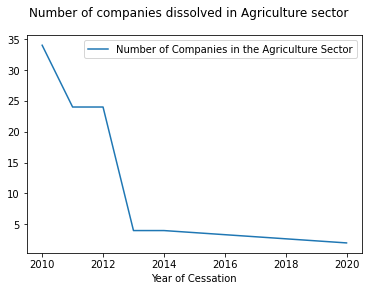

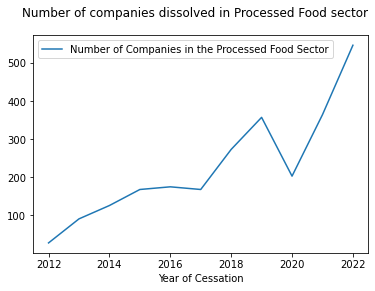

In [51]:
subplot_visualise_companies_dissolved(graph1,graph2)

From the table below, in the year 2020, the number of companies in the processed food sector had a 99% dissolving rate when compared to the total number of companies in that year. This shows the increasing difficulties in that sector to keep the companies going on. As seen in the table below the companies in the agriculture sector are performing well. 

In [52]:
modified_tabular_data

Year of Cessation     Sector Name  Number of Companies Average
0                2010     Agriculture                   34     1.0
1                2011     Agriculture                   24     1.0
2                2012     Agriculture                   24   0.462
3                2012  Processed Food                   28   0.538
4                2013     Agriculture                    4   0.042
5                2013  Processed Food                   91   0.958
6                2014     Agriculture                    4   0.031
7                2014  Processed Food                  126   0.969
8                2015  Processed Food                  168     1.0
9                2016  Processed Food                  175     1.0
10               2017  Processed Food                  168     1.0
11               2018  Processed Food                  273     1.0
12               2019  Processed Food                  357     1.0
13               2020     Agriculture                    2    0.01
14               2020  Processed Food                  203    0.99
15               2021  Processed Food                  364     1.0
16               2022  Processed Food                  546     1.0

Hence, the government should focus on the companies producing processed food and must support them. This maybe due to the after-effects of the pandemic. 

#### Inference

Since companies strictly belonging to a sector were considered, there were no data for companies in the poultry farming sector.

# Business Question 2:

### Business Question 2: Code:

In [2]:
raise NotImplementedError()

In [54]:
# Importing libraries
!pip3 install requests
import requests
import pprint as pp
import datetime
from datetime import date 
from datetime import datetime
import math
import time
import pickle
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [55]:
# function for calling the API to retrieve JSON
def call_api_with(url_extension):
    your_company_house_api_key ="fdfc7d90-70b1-4660-85ac-807e40cb8d72"
            
    login_headers = {"Authorization":your_company_house_api_key}
    url = f"https://api.company-information.service.gov.uk/{url_extension}"
    # above: could be eg. https://api.companieshouse.gov.uk/search/companies?q=shop&items_per_page=1
    print(f'requesting: {url}') 
    # above, optional: printing, so that you see visually how many calls you are making
    res = requests.get(url, headers=login_headers) #, verify=False)
    return res.json()

In [56]:
# advanced search - SIC codes & Date 
def companies_advanced_search(sic, number_of_companies):
    page_size = 100
    iterations_req = math.ceil(number_of_companies/page_size)
    companies = []
    for page_index in range(0, iterations_req):
        print('#Request: {0}'.format(page_index))
        url = f"advanced-search/companies?sic_codes={sic}&start_index={page_index*100}"
        companies += call_api_with(url).get('items', [])
    return page_index, companies

In [57]:
# request to get company data based on company number
def data_for_company(company_number):
    url = f"company/{company_number}"
    return call_api_with(url)

In [58]:
# function to write company information into a file
def read_write_company_information_to_pickle(sic_codes_list, company_details, company_details_df):
    no_of_requests = 1
    for i in range(0,len(sic_codes_list),4):
        for sic in sic_codes_list[i:i+4]:
            try:
                print('Try triggered')
                if no_of_requests%600!=0:
                    print('Requesting')
                    no_of_requests, company_details = companies_advanced_search(sic,10000) 
                    company_details_api_output_df = pd.DataFrame(company_details)
                    json_struct = json.loads(company_details_api_output_df.to_json(orient="records"))    
                    df_flat = pd.json_normalize(json_struct)
                    company_details_df = pd.concat([company_details_df, df_flat])
                    print('Saving to pickle file')
                    company_details_df.to_pickle('company_details.pkl')
                else:
                    print('Time delay for new window to start')
                    time.sleep(300)
            except:
                print('Except triggered')
                continue
        time.sleep(300)

In [59]:
#function to convert json variable to dataframe

def json_to_df(json_var):
    company_data_api_output_df = pd.DataFrame(json_var)
    json_struct = json.loads(company_data_api_output_df.to_json(orient="records"))    
    company_details_df2 = pd.json_normalize(json_struct)
    return company_details_df2

In [60]:
#list of sic codes for various sectors

sic_codes_list_rent_lease = [77110, 77120, 77210, 77220, 77291, 77299, 77310, 77320, 77330, 77341, 77342, 77351, 77352, 77390]
sic_codes_list_retail = [47190, 47210, 47220, 47230, 47240, 47250, 47260, 47290, 47300, 47410, 47421, 47429, 47430, 47510, 47520, 47530, 47540, 47591, 47599, 47610, 47620, 47630, 47640, 47650, 47710, 47721, 47722, 47730, 47741, 47749, 47750, 47760, 47770, 47781, 47782, 47789, 47791, 47799, 47810, 47820, 47890, 47910, 47990]
sic_codes_list_wholesale = [46210, 46220, 46230, 46240, 46310, 46320, 46330, 46341, 46342, 46350, 46360, 46370, 46380, 46390, 46410, 46420, 46431, 46439, 46440, 46450, 46460, 46470, 46480, 46491, 46499, 46510, 46520, 46610, 46620, 46630, 46640, 46650, 46660, 46690, 46711, 46719, 46720, 46730, 46740, 46750, 46760, 46770]

In [61]:
# lists and dataframes for various sectors in consideration
company_details_rent_lease = []
company_details_df_rent_lease = pd.DataFrame()

company_details_retail = []
company_details_df_retail = pd.DataFrame()

company_details_wholesale = []
company_details_df_wholesale = pd.DataFrame()

#Calling functions to request the company data in sectors: Rent & Lease sector, Retail sector, Wholesale sector
#read_write_company_information_to_pickle(sic_codes_list_rent_lease, company_details_rent_lease, company_details_df_rent_lease)
#read_write_company_information_to_pickle(sic_codes_list_retail, company_details_retail, company_details_df_retail)
#read_write_company_information_to_pickle(sic_codes_list_wholesale, company_details_wholesale, company_details_df_wholesale)

In [62]:
#calling function to read from pickle file
files_to_open = ['company_details_rent_lease.pkl', 'company_details_retail.pkl', 'company_details_wholesale.pkl']

company_data_df = reading_from_pickle(files_to_open)
company_data_df.head()

company_details_rent_lease.pkl
company_details_retail.pkl
company_details_wholesale.pkl


company_name company_number company_status company_type  \
0         DUNAR FOODS (UK) LIMITED       07905677      dissolved          ltd   
1              THE GRAINGE LIMITED       08002268         active          ltd   
2                  AUTOMAGICO LTD.       08462617      dissolved          ltd   
3  SOLIDROCK IMPORT-EXPORT LIMITED       08487346      dissolved          ltd   
4               WOODIMPEX (UK) LTD       08129761      dissolved          ltd   

                     kind date_of_cessation date_of_creation       sic_codes  \
0  search-results#company        2016-05-17       2012-01-11         [46210]   
1  search-results#company              None       2012-03-22         [46210]   
2  search-results#company        2015-04-28       2013-03-26  [46210, 47760]   
3  search-results#company        2015-04-21       2013-04-15         [46210]   
4  search-results#company        2020-11-17       2012-07-04         [46210]   

  links.company_profile registered_office_address.address_line_1  \
0     /company/07905677                            Kajaine House   
1     /company/08002268                           29 Temple Lane   
2     /company/08462617                  Dept 302 43 Owston Road   
3     /company/08487346                       31a Grovehill Road   
4     /company/08129761                Unit 19 165 Columbia Road   

  registered_office_address.address_line_2 registered_office_address.locality  \
0                        57-67 High Street                            Edgware   
1                             Copmanthorpe                               York   
2                                 Carcroft                          Doncaster   
3                                      NaN                            Redhill   
4                             Ensbury Park                        Bournemouth   

  registered_office_address.postal_code registered_office_address.region  \
0                               HA8 7DD                        Middlesex   
1                              YO23 3TB                  North Yorkshire   
2                               DN6 8DA                  South Yorkshire   
3                               RH1 6PJ                           Surrey   
4                              BH10 4EE                              NaN   

  registered_office_address.country company_subtype  
0                               NaN             NaN  
1                               NaN             NaN  
2                           England             NaN  
3                               NaN             NaN  
4                               NaN             NaN

In [63]:
#Extracting required columns
company_data_df = company_data_df[['company_number','sic_codes', 'company_status','date_of_creation']]

#Removing information of companies that are dissolved and liquidated
company_data_df = company_data_df[company_data_df["company_status"].str.contains("dissolved" or "liquidation") == False]

#Removing information of companies depending on date i.e., considering information of companies created in the years 2019 and 2020
company_data_df = company_data_df.loc[(company_data_df['date_of_creation'] >= '2019-01-01') & (company_data_df['date_of_creation'] < '2020-12-01')]

company_data_df.head()

company_number                     sic_codes company_status  \
31       11840611                       [46210]         active   
32       12643174  [46190, 46210, 46310, 46342]         active   
35       12614662         [01430, 46210, 77310]         active   
38       13041067                       [46210]         active   
42       12941212                       [46210]         active   

   date_of_creation  
31       2019-02-21  
32       2020-06-03  
35       2020-05-20  
38       2020-11-24  
42       2020-10-09

In [64]:
#dropping columns without values
company_data_df = company_data_df.dropna(axis=0)

#removing square brackets from sic codes
f = lambda x: ','.join(map(str, x)) if isinstance(x, list) else x
company_data_df['sic_codes'] = company_data_df['sic_codes'].apply(f)

company_data_df.head()

company_number                sic_codes company_status date_of_creation
31       11840611                    46210         active       2019-02-21
32       12643174  46190,46210,46310,46342         active       2020-06-03
35       12614662        01430,46210,77310         active       2020-05-20
38       13041067                    46210         active       2020-11-24
42       12941212                    46210         active       2020-10-09

In [65]:
#creating column with sector names from sic codes

def categorise1(row):  
    if row['sic_codes'] in ('77110', '77120', '77210', '77220', '77291', '77299', '77310', '77320', '77330', '77341', '77342', '77351', '77352', '77390' ):
        return 'Rent & Lease'
    elif row['sic_codes'] in ('47190', '47210', '47220', '47230', '47240', '47250', '47260', '47290', '47300', '47410', '47421', '47429', '47430', '47510', '47520', '47530', '47540', '47591', '47599', '47610', '47620', '47630', '47640', '47650', '47710', '47721', '47722', '47730', '47741', '47749', '47750', '47760', '47770', '47781', '47782', '47789', '47791', '47799', '47810', '47820', '47890', '47910', '47990'):
        return 'Retail'
    elif row['sic_codes'] in ('46210', '46220', '46230', '46240', '46310', '46320', '46330', '46341', '46342', '46350', '46360', '46370', '46380', '46390', '46410', '46420', '46431', '46439', '46440', '46450', '46460', '46470', '46480', '46491', '46499', '46510', '46520', '46610', '46620', '46630', '46640', '46650', '46660', '46690', '46711', '46719', '46720', '46730', '46740', '46750', '46760', '46770'):
        return 'Wholesale'
    return 'extra'


company_data_df['sector_name'] = company_data_df.apply(categorise1, axis=1)
company_data_df.head()

company_number                sic_codes company_status date_of_creation  \
31       11840611                    46210         active       2019-02-21   
32       12643174  46190,46210,46310,46342         active       2020-06-03   
35       12614662        01430,46210,77310         active       2020-05-20   
38       13041067                    46210         active       2020-11-24   
42       12941212                    46210         active       2020-10-09   

   sector_name  
31   Wholesale  
32       extra  
35       extra  
38   Wholesale  
42   Wholesale

In [66]:
#Removing company information where a company belongs to more than one sector
company_data_df = company_data_df[company_data_df["sector_name"].str.contains("extra") == False]

#extracting year from date of creation of companies
company_data_df['date_of_creation'] = pd.to_datetime(company_data_df['date_of_creation'])
company_data_df['Year'] = company_data_df['date_of_creation'].dt.year
company_data_df.head()

company_number sic_codes company_status date_of_creation sector_name  Year
31        11840611     46210         active       2019-02-21   Wholesale  2019
38        13041067     46210         active       2020-11-24   Wholesale  2020
42        12941212     46210         active       2020-10-09   Wholesale  2020
102       12390410     46210         active       2020-01-07   Wholesale  2020
180       12134598     46210         active       2019-08-01   Wholesale  2019

In [81]:
# # Creating a function to retreive information about companies data by making api calls by passing various company numbers

# company_numbers_list = company_data_df['company_number'].values.tolist()

# def requests_for_json_data(list):
#     data = []
#     no_of_requests = 1
#     for j in company_numbers_list:
#             data.append(data_for_company(j))
#             no_of_requests+=1
#             if no_of_requests%600!=0:
#                 continue
#             else:
#                 print('Time delay for new window to start')
#                 time.sleep(300)   
#     return data

# capturing_json_data = requests_for_json_data(company_numbers_list)   

In [82]:
# #Calling function to convert json variable to dataframe
# company_data_api_df2 = json_to_df(capturing_json_data)

In [83]:
# #Writing to pickle file
# company_data_api_df2.to_pickle('company_details.pkl')

In [70]:
#Reading from pickle file
company_data_api_df2 = reading_from_pickle(['company_details.pkl'])
company_data_api_df2.head()

company_details.pkl


company_number  undeliverable_registered_office_address   jurisdiction  \
0       11840611                                    False  england-wales   
1       13041067                                    False  england-wales   
2       12941212                                    False  england-wales   
3       12390410                                    False  england-wales   
4       12134598                                    False  england-wales   

  company_status                company_name  \
0         active              NIKTA RICE LTD   
1         active    VK INTERNATIONAL PVT LTD   
2         active  PAGODA TRADE SOLUTIONS LTD   
3         active                  ANUMUL LTD   
4         active         VERTURO TRADING LTD   

                                       etag  has_insolvency_history  \
0  3972edd94f556f9a24fc65b8a92d1b064eb4b8f7                   False   
1  7e8c9855ac27a931ce3d7a179b205a526f412f25                   False   
2  ac14db74aafb57154117ef8088e9d8ec8ad74aff                   False   
3  5fa74c07a858f0bb807b5a2f27ae341d16a656f4                   False   
4  ee277651bf00923b7fc304bfa3ccf20ace6f503e                   False   

   registered_office_is_in_dispute  has_charges type  ...  \
0                            False        False  ltd  ...   
1                            False        False  ltd  ...   
2                            False        False  ltd  ...   
3                            False        False  ltd  ...   
4                            False        False  ltd  ...   

  registered_office_address.address_line_1  \
0                            Liberty House   
1                 17 Cowper Avenue Foxhill   
2                       42 Berkeley Square   
3             Jml Accountancy Services Ltd   
4  Office 323 Regico Offices, The Old Bank   

  registered_office_address.address_line_2 registered_office_address.country  \
0                       30 Whitchurch Lane                           England   
1                                      NaN                           England   
2                                      NaN                           England   
3                          64 Drake Street                           England   
4               153 The Parade High Street                    United Kingdom   

   links.persons_with_significant_control_statements  links.charges  \
0                                                NaN            NaN   
1                                                NaN            NaN   
2                                                NaN            NaN   
3                                                NaN            NaN   
4  /company/12134598/persons-with-significant-con...            NaN   

  registered_office_address.region links.insolvency links.registers  \
0                              NaN              NaN             NaN   
1                              NaN              NaN             NaN   
2                              NaN              NaN             NaN   
3                              NaN              NaN             NaN   
4                              NaN              NaN             NaN   

  confirmation_statement registered_office_address.po_box  
0                    NaN                              NaN  
1                    NaN                              NaN  
2                    NaN                              NaN  
3                    NaN                              NaN  
4                    NaN                              NaN  

[5 rows x 50 columns]

In [71]:
#Extracting required columns
company_data_api_df2 = company_data_api_df2[['sic_codes', 'company_number', 'has_charges']]
company_data_api_df2.head()

sic_codes company_number  has_charges
0   [46210]       11840611        False
1   [46210]       13041067        False
2   [46210]       12941212        False
3   [46210]       12390410        False
4   [46210]       12134598        False

In [72]:
#merging two dataframes to get sector name along with the company data details
merged_df = company_data_df.merge(company_data_api_df2, on = 'company_number')
merged_df = merged_df[['sector_name','company_status','has_charges','Year']]
merged_df.head()

sector_name company_status  has_charges  Year
0   Wholesale         active        False  2019
1   Wholesale         active        False  2019
2   Wholesale         active        False  2019
3   Wholesale         active        False  2019
4   Wholesale         active        False  2019

In [73]:
#Creating two dataframes with information on companies depending on whether they have charges or not
without_charges_df = merged_df.loc[merged_df['has_charges'] == False]
with_charges_df = merged_df.loc[merged_df['has_charges'] == True]

In [74]:
#Creating a function to groupby data on the year and sector name
def groupby_company_data(df_to_alter):
    df_to_alter = df_to_alter[['Year','sector_name']]
    df_to_alter = df_to_alter[['sector_name','Year']].groupby(['Year','sector_name']).size().to_frame().reset_index(drop=False)
    df_to_alter.columns.values[0:3] =["Year of Creation", "Sector Name", "Number of Companies" ]
    df_to_alter.columns = df_to_alter.columns.str.strip()
    return df_to_alter

without_charges_df2 = groupby_company_data(without_charges_df)
with_charges_df2 = groupby_company_data(with_charges_df)

without_charges_df2
with_charges_df2     
    

Year of Creation   Sector Name  Number of Companies
0              2019  Rent & Lease                   41
1              2019        Retail                  242
2              2019     Wholesale                  645
3              2020  Rent & Lease                   29
4              2020        Retail                  847
5              2020     Wholesale                  463

In [75]:
merged_df_graph_data = merged_df[['sector_name','Year','has_charges']].groupby(['Year','sector_name','has_charges']).size().to_frame().reset_index(drop=False)
merged_df_graph_data

Year   sector_name  has_charges      0
0   2019  Rent & Lease        False   1440
1   2019  Rent & Lease         True     41
2   2019        Retail        False  30581
3   2019        Retail         True    242
4   2019     Wholesale        False   7837
5   2019     Wholesale         True    645
6   2020  Rent & Lease        False   1692
7   2020  Rent & Lease         True     29
8   2020        Retail        False  33168
9   2020        Retail         True    847
10  2020     Wholesale        False  11536
11  2020     Wholesale         True    463

In [76]:
merged_df_graph_data.columns.values[0:4] =["Year of Creation", "Sector Name","Legal Charges", "Number of Companies" ]
merged_df_graph_data.columns = merged_df_graph_data.columns.str.strip()
merged_df_graph_data

Year of Creation   Sector Name  Legal Charges  Number of Companies
0               2019  Rent & Lease          False                 1440
1               2019  Rent & Lease           True                   41
2               2019        Retail          False                30581
3               2019        Retail           True                  242
4               2019     Wholesale          False                 7837
5               2019     Wholesale           True                  645
6               2020  Rent & Lease          False                 1692
7               2020  Rent & Lease           True                   29
8               2020        Retail          False                33168
9               2020        Retail           True                  847
10              2020     Wholesale          False                11536
11              2020     Wholesale           True                  463

In [2]:
#set seaborn plotting aesthetics

def barchart_plot_charge_included(df):
    sns.set(style='white',rc={'figure.figsize':(13.7,11.27)})
    sns.catplot(x="Year of Creation", y="Number of Companies", hue="Sector Name", col="Legal Charges", data=df, kind="bar", height=4, aspect=1)
            

In [1]:
#set seaborn plotting aesthetics

def barchart_plot(df):
    sns.set(style='white',rc={'figure.figsize':(11.7,9.27)})
    sns.barplot(x="Year of Creation", y="Number of Companies", hue="Sector Name", data=df)

# Business Question 2: Inference

Details of companies in the renting and leasing, retail and wholesale sectors were retrieved, from Company House API, and were analysed to see which sectors were promising. Companies that were created in the years 2019 and 2020 were considered. During these two years if the companies in these sectors had legal charges due to the difficulties posed by the pandemic, then they were considered to be less robust and did not promise returns. 

From the graphs below, it is clear that the companies in the retail sector were promising due to the low number of legal charges against them. This may be due to the e-commerce option available to the customers. Even though the rent and lease sector did not receive any legal charges against them, since their numbers are small in number, the returns may not be that high.

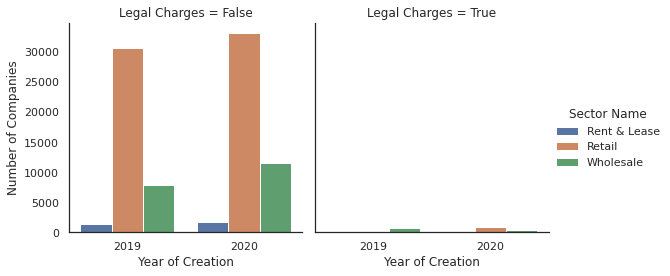

In [79]:
barchart_plot_charge_included(merged_df_graph_data)


From the graph below, more companies were created in the retail sector. Despite the difficulties the pandemic posed in 2019, a greater number of companies were added in 2020 which is around 16,500 over the 15000 companies in 2019. This shows that the retail sector is promising with several options to choose from that will give robust returns due to its flexibility to increase sales online and offline.

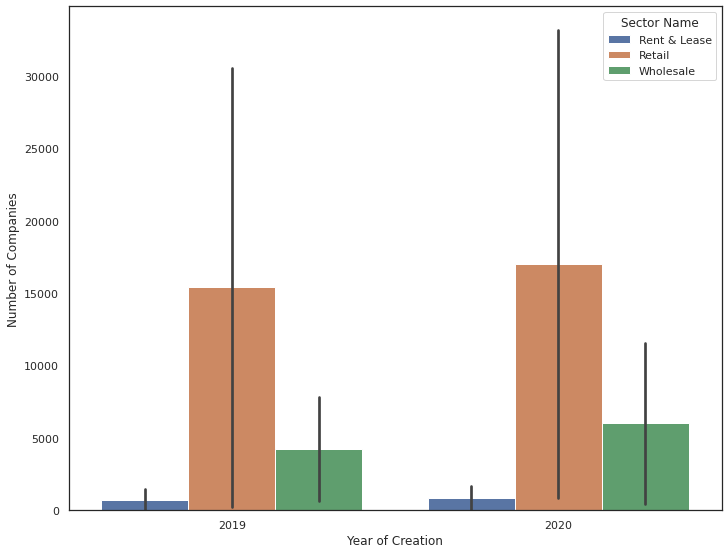

In [80]:
barchart_plot(merged_df_graph_data)